In [2]:
# all imports
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# import torch
# import torch.nn as nn

## Data Handling and Displaying

**Task:**

1. Read Birkshire Hathaway CSV file.
2. Cure the Data.
    - Convert time format to Julian.
    - Add a "Mid" feature that averages the open and close prices.
    - Drop "Open" and "Close" features.
3. Display Data.
    - Print number of days of data.
    - Print the data header before and after curing.
    - Plot "Mid" the mid feature over julian time.

Number of entries: 2408


Raw data:
         Date        Open       Close
0  2015-01-02  151.500000  149.169998
1  2015-01-05  148.809998  147.000000
2  2015-01-06  147.639999  146.839996
3  2015-01-07  147.940002  148.880005
4  2015-01-08  150.600006  151.369995
5  2015-01-09  151.649994  149.470001
6  2015-01-12  149.960007  148.279999
7  2015-01-13  149.949997  148.630005
8  2015-01-14  147.270004  147.820007
9  2015-01-15  148.529999  147.580002


After curating data:
      Date         Mid
0  2457024  150.334999
1  2457027  147.904999
2  2457028  147.239998
3  2457029  148.410004
4  2457030  150.985001
5  2457031  150.559998
6  2457034  149.120003
7  2457035  149.290001
8  2457036  147.545006
9  2457037  148.055000


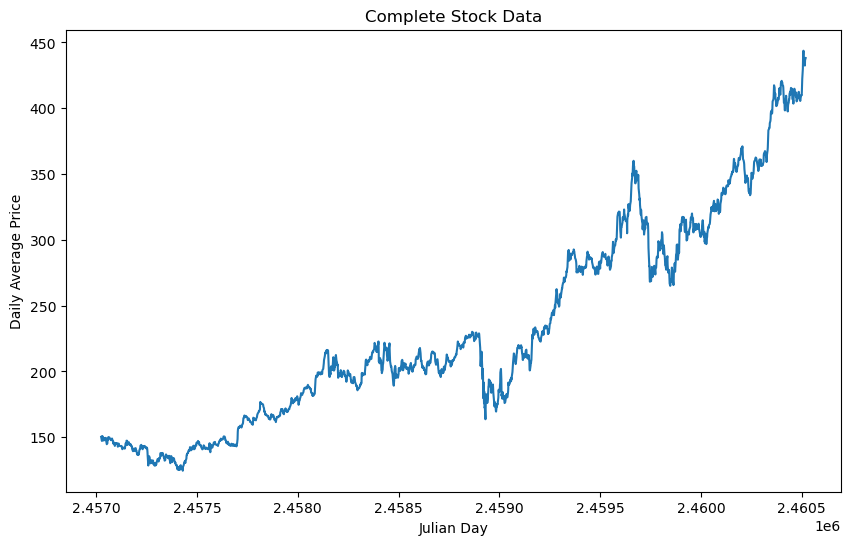

In [3]:
# Parse CSV
# Data pulled from https://www.kaggle.com/datasets/umerhaddii/berkshire-hathaway-stock-price-data
# Using the data curation from https://github.com/hemangjoshi37a/TrendMaster/blob/main/trendmaster/data_loader.py
firstDF = pd.read_csv('stocks.csv')[['Date', 'Open', 'Close']]
print("Number of entries:", len(firstDF['Date'].values))
print("\n\nRaw data:")
print(firstDF.head(10))

# Get Julian day and average the open and close values for the day as a new feature, "Mid"
firstDF['Date'] = firstDF['Date'].apply(lambda x: pd.to_datetime(x).to_julian_date().astype(int))
firstDF['Mid'] = (firstDF['Open'] + firstDF['Close']) / 2
firstDF = firstDF.drop(columns=['Open', 'Close'])
print("\n\nAfter curating data:")
print(firstDF.head(10))

# Display data
plt.figure(figsize=(10, 6))
plt.plot(firstDF['Date'].values, firstDF['Mid'].values)
plt.title("Complete Stock Data")
plt.xlabel("Julian Day")
plt.ylabel("Daily Average Price")
plt.show()

## Displaying Continued

**Task:**

1. Create X, y, and their corresponding training and testing variables.
2. Plot the data once again, this time displaying the test / train split.



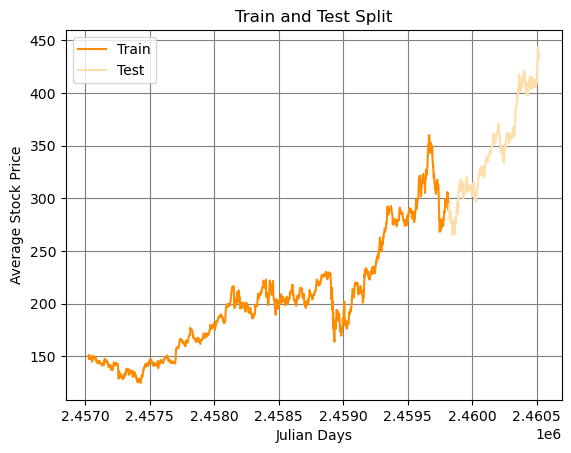

In [50]:
# Convert raw dataframe into average price over time

# Split this data into train and test data
# pick an indice to split on 
X = np.squeeze(firstDF[['Date']].values)
y = np.squeeze(firstDF[['Mid']].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# scaled data variables for later (lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform((X_train).reshape(-1, 1))
X_test_scaled = scaler.transform((X_test).reshape(-1, 1))
X_scaled = scaler.transform((X).reshape(-1, 1))

# display
plt.figure()
plt.clf()

plt.plot(X_train, y_train, label="Train", color="darkorange")
plt.plot(X_test, y_test, label="Test", color="navajowhite")

plt.grid(color="grey")
plt.xlabel("Julian Days")
plt.ylabel("Average Stock Price")
plt.title("Train and Test Split")
plt.legend()
plt.show()

## Creating the model and evaluation

**Task:**

1. Create and fit a linear regression model to the data.
2. Print MSE and R2 score of the model.
3. Graph the predictions of the model.

MSE: 2538.38
R2 Score: -0.28


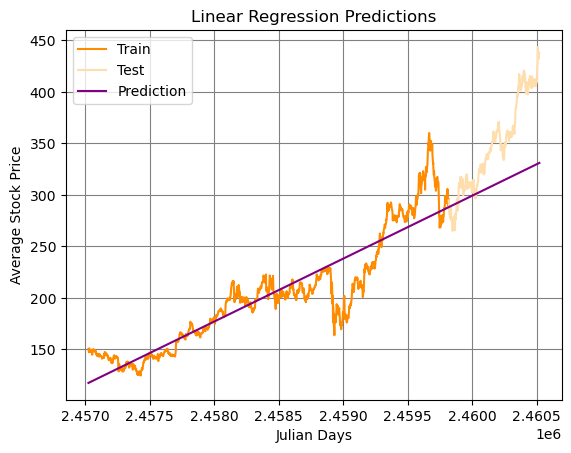

In [51]:
# declare and train model
model = LinearRegression()
model.fit(X_train.reshape(-1,1), y_train)

# predict
y_pred = model.predict(X_test.reshape(-1,1))
y_pred_full = model.predict(X.reshape(-1,1))

# performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

# display
plt.figure()

plt.clf()
plt.plot(X_train, y_train, label="Train", color="darkorange")
plt.plot(X_test, y_test, label="Test", color="navajowhite")
plt.plot(X, y_pred_full, label="Prediction", color="purple")

plt.grid(color="grey")
plt.xlabel("Julian Days")
plt.ylabel("Average Stock Price")
plt.title("Linear Regression Predictions")
plt.legend()
plt.show()

## Comparison to Lasso Regularization

**Task:**

1. Create and fit a lasso model to the data testing several alpha vaues.
2. Print MSE and R2 score of each lasso alpha value and compare to linear regression model.
3. Graph and compare the predictions of the best lasso alpha to linear regression model.

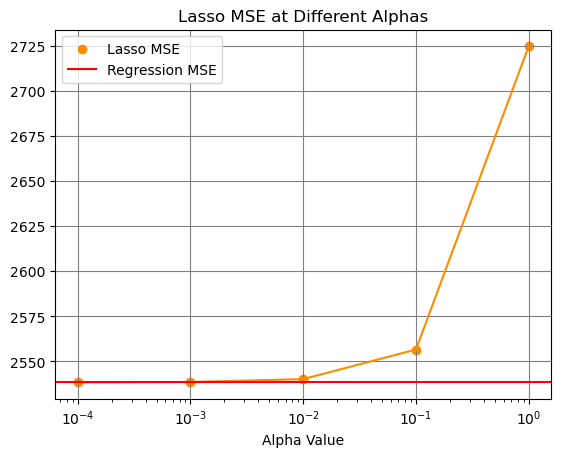

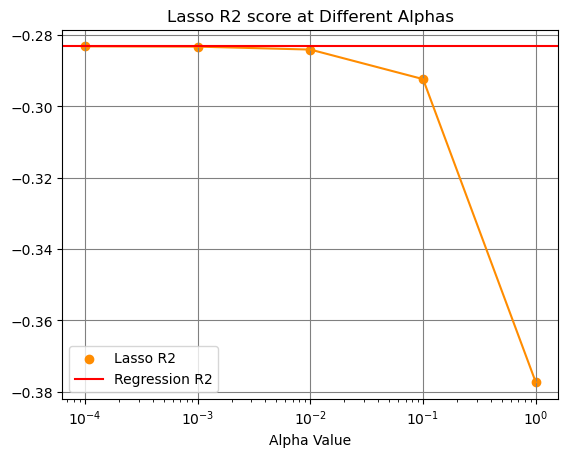

For alpha = 0.0001 on Lasso:

MSE:
	Regression: 2538.38
	Lasso: 2538.40

R2 Score:
	Regression: -0.2832
	Lasso: -0.2832


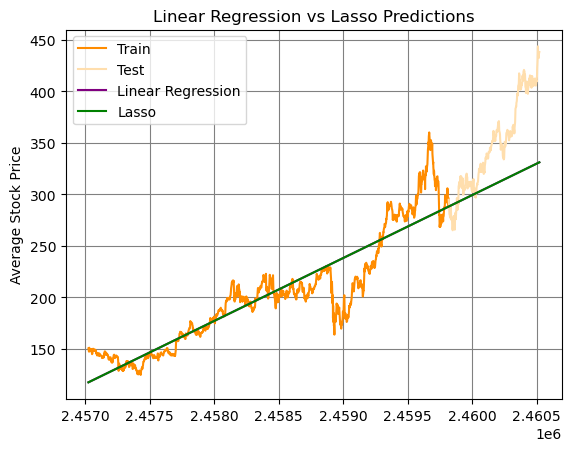

In [67]:
# dictionary that stores all the data for below graphs
lasso_data = {
    'alphas':[0.0001, 0.001, 0.01, 0.1, 1],
    'MSEs':[],
    'R2s':[]
}

# find MSE and R2 for each alpha
for alpha in lasso_data['alphas']:

    # lasso decleration and training
    lasso_model = linear_model.Lasso(alpha=alpha)
    lasso_model.fit(X_train_scaled, y_train)

    # predict
    lasso_pred = lasso_model.predict(X_test_scaled)
    lasso_pred_full = lasso_model.predict(X_scaled)

    # performance metrics
    lasso_mse = mean_squared_error(y_test, lasso_pred)
    lasso_r2 = r2_score(y_test, lasso_pred)

    lasso_data['MSEs'].append(lasso_mse)
    lasso_data['R2s'].append(lasso_r2)


# mse graph
plt.figure()
plt.clf()

# lasso mse
plt.plot(lasso_data['alphas'], lasso_data['MSEs'], color = "darkorange")
plt.scatter(lasso_data['alphas'], lasso_data['MSEs'], label = "Lasso MSE", color = "darkorange")

# regression mse
plt.axhline(y = mse, color = "red", label = "Regression MSE")

plt.xscale('log')
plt.grid(color="grey")
plt.xlabel("Alpha Value")
plt.title("Lasso MSE at Different Alphas")
plt.legend()
plt.show()

# r2 graph
plt.figure()
plt.clf()

# lasso r2
plt.plot(lasso_data['alphas'], lasso_data['R2s'], color = "darkorange")
plt.scatter(lasso_data['alphas'], lasso_data['R2s'], label = "Lasso R2", color = "darkorange")

# regression r2
plt.axhline(y = r2, color = "red", label = "Regression R2")

plt.xscale('log')
plt.grid(color="grey")
plt.xlabel("Alpha Value")
plt.title("Lasso R2 score at Different Alphas")
plt.legend()
plt.show()

# for the next graph, we'll be using the best alpha, 0.0001, to visualize lasso predictions vs regression
lasso_model = linear_model.Lasso(alpha=0.0001)
lasso_model.fit(X_train_scaled, y_train)
lasso_pred = lasso_model.predict(X_test_scaled)
lasso_pred_full = lasso_model.predict(X_scaled)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)

# printing performance metrics for the best lasso's best alpha
print(f"For alpha = 0.0001 on Lasso:\n")
print(f"MSE:\n\tRegression: {mse:.2f}\n\tLasso: {lasso_mse:.2f}\n")
print(f"R2 Score:\n\tRegression: {r2:.4f}\n\tLasso: {lasso_r2:.4f}")

# displaying predictions vs regression
plt.figure()
plt.clf()

plt.plot(X_train, y_train, label="Train", color="darkorange")
plt.plot(X_test, y_test, label="Test", color="navajowhite")
plt.plot(X, y_pred_full, label="Linear Regression", color="purple")
plt.plot(X, lasso_pred_full, label="Lasso", color="green")

plt.grid(color="grey")
plt.ylabel("Average Stock Price")
plt.title("Linear Regression vs Lasso Predictions")
plt.legend()
plt.show()